## Data Collection

### Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import datetime as dt

from wordcloud import WordCloud, STOPWORDS
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#load dataset
sales = pd.read_excel("/content/drive/My Drive/Dataset_Literata/Dataset_Literata.xlsx")
sales

,No. Invoice,Tanggal Invoice,Kode Barang,Nama Customer,Nama Barang,Qty,Harga,Total
0,INV/20200701/001,2020-07-01 09:10:20.000,15000001,Tilar Handayani,"TAMA HEALTHY MASK - NON MEDICAL 3PLY, WHO RECO...",9,18750,168750
1,NaN,NaT,30000007,NaN,"LIBI, LEBAH KECIL YANG TAKUT - PENGARANG POPI...",9,43800,394200
2,NaN,NaT,61000008,NaN,BB L/L 100L B5 (50),9,8900,80100
3,NaN,NaT,61000012,NaN,BB L/L A5 100 GREEN (50),9,9400,84600
4,NaN,NaT,61000016,NaN,BB L/L A5 100 YELLOW (50),9,9400,84600
...,...,...,...,...,...,...,...,...
8589,NaN,NaT,91000126,NaN,KIKY AMP MERPATI 90 60GR (70),2,18900,37800
8590,NaN,NaT,91000145,NaN,KIKY B/KWARTO 200L (60),1,23900,23900
8591,INV/20201130/7705,2020-11-30 17:28:20.995,91000186,Helvy,PAPER ONE HVS 70GR F4,2,45000,90000
8592,NaN,NaT,91000392,NaN,ZB SARASA CLIP 07 BLUE,1,19500,19500


In [ ]:
sales.columns

Index(['No. Invoice', 'Tanggal Invoice', 'Kode Barang', 'Nama Customer ',
       'Nama Barang ', 'Qty', 'Harga ', 'Total'],
      dtype='object')

In [ ]:
# Ubah jadi tipe data tanggal
sales["Tanggal Invoice"] = pd.to_datetime(sales["Tanggal Invoice"])
sales.dtypes

No. Invoice                object
Tanggal Invoice    datetime64[ns]
Kode Barang                 int64
Nama Customer              object
Nama Barang                object
Qty                         int64
Harga                       int64
Total                      object
dtype: object

### Cleansing Data

In [ ]:
#Identifikasi Missing Value

# memeriksa persentase nilai nan yang ada di setiap fitur
# membuat daftar fitur yang memiliki missing value
features_with_na=[features for features in sales.columns if sales[features].isnull().sum()>1]

## cetak nama fitur dan persentase missing value
for feature in features_with_na:
    print(feature, np.round(sales[feature].isnull().mean(), 4), ' % missing values')

No. Invoice 0.6542  % missing values
Tanggal Invoice 0.6545  % missing values
Nama Customer  0.6582  % missing values


In [ ]:
#forward fill missing value 
sales = sales.ffill()

In [ ]:
#check missing value 
sales.isnull().sum()

No. Invoice        0
Tanggal Invoice    0
Kode Barang        0
Nama Customer      0
Nama Barang        0
Qty                0
Harga              0
Total              0
dtype: int64

In [ ]:
sales

,No. Invoice,Tanggal Invoice,Kode Barang,Nama Customer,Nama Barang,Qty,Harga,Total
0,INV/20200701/001,2020-07-01 09:10:20.000,15000001,Tilar Handayani,"TAMA HEALTHY MASK - NON MEDICAL 3PLY, WHO RECO...",9,18750,168750
1,INV/20200701/001,2020-07-01 09:10:20.000,30000007,Tilar Handayani,"LIBI, LEBAH KECIL YANG TAKUT - PENGARANG POPI...",9,43800,394200
2,INV/20200701/001,2020-07-01 09:10:20.000,61000008,Tilar Handayani,BB L/L 100L B5 (50),9,8900,80100
3,INV/20200701/001,2020-07-01 09:10:20.000,61000012,Tilar Handayani,BB L/L A5 100 GREEN (50),9,9400,84600
4,INV/20200701/001,2020-07-01 09:10:20.000,61000016,Tilar Handayani,BB L/L A5 100 YELLOW (50),9,9400,84600
...,...,...,...,...,...,...,...,...
8589,INV/20201130/7701,2020-11-30 16:42:16.995,91000126,Intane Jun Pyo,KIKY AMP MERPATI 90 60GR (70),2,18900,37800
8590,INV/20201130/7701,2020-11-30 16:42:16.995,91000145,Intane Jun Pyo,KIKY B/KWARTO 200L (60),1,23900,23900
8591,INV/20201130/7705,2020-11-30 17:28:20.995,91000186,Helvy,PAPER ONE HVS 70GR F4,2,45000,90000
8592,INV/20201130/7705,2020-11-30 17:28:20.995,91000392,Helvy,ZB SARASA CLIP 07 BLUE,1,19500,19500


### Random Labelling

In [ ]:
sales["Nama Customer "] = sales["Nama Customer "].astype('category')
sales["CustomerID"] = sales["Nama Customer "].cat.codes
sales

,No. Invoice,Tanggal Invoice,Kode Barang,Nama Customer,Nama Barang,Qty,Harga,Total,CustomerID
0,INV/20200701/001,2020-07-01 09:10:20.000,15000001,Tilar Handayani,"TAMA HEALTHY MASK - NON MEDICAL 3PLY, WHO RECO...",9,18750,168750,1416
1,INV/20200701/001,2020-07-01 09:10:20.000,30000007,Tilar Handayani,"LIBI, LEBAH KECIL YANG TAKUT - PENGARANG POPI...",9,43800,394200,1416
2,INV/20200701/001,2020-07-01 09:10:20.000,61000008,Tilar Handayani,BB L/L 100L B5 (50),9,8900,80100,1416
3,INV/20200701/001,2020-07-01 09:10:20.000,61000012,Tilar Handayani,BB L/L A5 100 GREEN (50),9,9400,84600,1416
4,INV/20200701/001,2020-07-01 09:10:20.000,61000016,Tilar Handayani,BB L/L A5 100 YELLOW (50),9,9400,84600,1416
...,...,...,...,...,...,...,...,...,...
8589,INV/20201130/7701,2020-11-30 16:42:16.995,91000126,Intane Jun Pyo,KIKY AMP MERPATI 90 60GR (70),2,18900,37800,745
8590,INV/20201130/7701,2020-11-30 16:42:16.995,91000145,Intane Jun Pyo,KIKY B/KWARTO 200L (60),1,23900,23900,745
8591,INV/20201130/7705,2020-11-30 17:28:20.995,91000186,Helvy,PAPER ONE HVS 70GR F4,2,45000,90000,648
8592,INV/20201130/7705,2020-11-30 17:28:20.995,91000392,Helvy,ZB SARASA CLIP 07 BLUE,1,19500,19500,648


In [ ]:
#preview data distribution
sales.describe()

,Kode Barang,Qty,Harga,CustomerID
count,8.594000e+03,8594.000000,8594.000000,8594.000000
mean,7.054470e+07,5.680009,15248.584478,768.740982
std,1.507259e+07,109.112681,22879.632104,443.057847
min,6.601000e+03,0.000000,1000.000000,0.000000
25%,6.100041e+07,2.000000,4000.000000,386.250000
50%,6.300020e+07,4.000000,7800.000000,777.000000
75%,8.200001e+07,6.000000,17500.000000,1139.000000
max,9.200006e+07,10110.000000,270000.000000,1550.000000


**Dengan melihat perbedaan angka antara median (50%) dan Mean yang tidak terlalu jauh, disimpulkan : Jumlah transaksi sedikit beragam dan tidak terdapat anomali *antar* pelanggan.**

In [ ]:
#inspect null value
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   No. Invoice      8594 non-null   object        
 1   Tanggal Invoice  8594 non-null   datetime64[ns]
 2   Kode Barang      8594 non-null   int64         
 3   Nama Customer    8594 non-null   category      
 4   Nama Barang      8594 non-null   object        
 5   Qty              8594 non-null   int64         
 6   Harga            8594 non-null   int64         
 7   Total            8594 non-null   object        
 8   CustomerID       8594 non-null   int16         
dtypes: category(1), datetime64[ns](1), int16(1), int64(3), object(3)
memory usage: 555.8+ KB


In [ ]:
sales.to_excel("/content/drive/My Drive/Dataset_Literata/1. Hasil_Cleansing.xlsx", index=False)

# **Data Understanding**

***Initial Check***

1. How many unique customers
2. How many products per invoice?
3. What kind of products, how many product item?
4. Time bound

***Exploratory Data Analysis*** **bold text**
1. How many product sold every month, nd how much every customer spend money every month
2. New Customer every month
3. Retention rate every month
4. Jarak rata-rata antar transaksi

In [ ]:
#Delete data with no CustomerID
sales = sales.loc[sales["CustomerID"].isna()==False]
sales.shape

(8594, 9)

**1. How many unique customers?**

In [ ]:
sales["CustomerID"].nunique() 

1551

**2. How many product per invoice?**

In [ ]:
sales.groupby("No. Invoice", as_index=False)[["Kode Barang"]].count()

,No. Invoice,Kode Barang
0,,1
1,INV/20200701/001,5
2,INV/20200701/0010,1
3,INV/20200701/0011,1
4,INV/20200701/0012,1
...,...,...
2967,INV/20201130/7693,3
2968,INV/20201130/7696,3
2969,INV/20201130/7699,2
2970,INV/20201130/7701,4


**3. Produk apa saja yang dijual?**

In [ ]:
products_desc = '|'.join(sales["Nama Barang "].unique())

In [ ]:
products_desc
#some products : PaperOne A4, Joyko, Kiky etc

'TAMA HEALTHY MASK - NON MEDICAL 3PLY, WHO RECOMMENDED|LIBI,  LEBAH KECIL YANG TAKUT - PENGARANG POPIE LARASATI|BB L/L 100L B5 (50)|BB L/L A5 100 GREEN (50)|BB L/L A5 100 YELLOW (50)|BB L/L B5 100 RAINBOW(25)|BTF BUSUR 180/10 (960)|BTF MST 15CM (2400)|BTF MST 30CM WARNA (1200)|BTF MST 30CM(1200)|BTF MST 40CM (480)|BTF MST BT 8000|BTF MST CLASSIC CLEAR 30 CM|BTF SEGITIGA NO.6 (192)|DAI DCS C/SLEEVES A4 1 CLAS RED|JOYKO CT-507 TIPP-EX ROL(720)|JOYKO CT-553 CORECTION TAPE (432)|JOYKO ER 110 ERASER|K/MINYAK KUNING (500)|K/SAMSON HALUS 80GR|KIKY SKETCHBOOK 50 A5 (60)|KIKY STOP MAP BATIK (500)|B/BOSS B/TULIS EB 42B/6 LUCU(24)|KENKO GLUE STICK GS02, 15G NET.|KIKY B/TULIS DIKTAT 40L/5 (50)|KISTOCK KWARTO (200)|IMAIE MST YS-683 30CM|CNC  CVR LAID 80539 F4 220G/10L GOLD YELLOW|DAIMARU D/TAPE 1/2"" 12Y(240)|FBC 115851 P/WARNA 12C CLASIC|JOYKO GL-R35 GLUE (576)|JOYKO INDEX MEMO IM-32 (1080)|JOYKO KR6 KEY RING (200)|JOYKO TRIGONAL  CLIP NO.1|KIKY B/GAMBAR 20X30 (240)|KIKY B/GAMBAR B (200)|KIKY B/GA

**Draw into wordcloud**

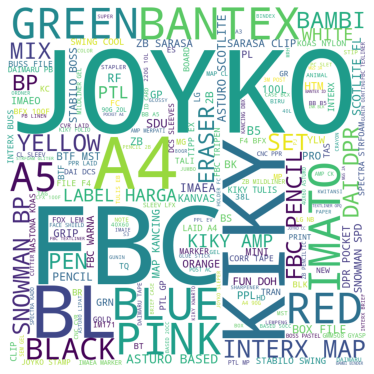

In [ ]:
wcloud = WordCloud(width=800, height=800,background_color="white",stopwords=STOPWORDS,max_words=200 ).generate(products_desc)
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

**How many unique product**

In [ ]:
sales["Kode Barang"].nunique()

1318

**4. Timebound Data**

In [ ]:
#timebound
print(sales["Tanggal Invoice"].min())
print(sales["Tanggal Invoice"].max())
print("The data is from 5 month transaction")

2020-07-01 09:10:20
2020-11-30 17:28:20.995000
The data is from 5 month transaction


## Exploratory Data Analysis

In [ ]:
sales['month-Year'] = sales["Tanggal Invoice"].apply(lambda x: 100*x.year + x.month)
sales['Total'] = sales['Qty'] * sales['Harga '] 

In [ ]:
sales['month-Year'].unique()

array([202007, 202008, 202009, 202010, 202011])

Text(0.5, 1.0, 'Total Transaksi Per Bulan')

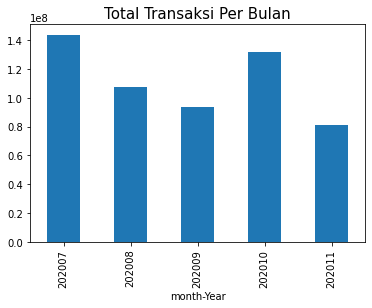

In [ ]:
sales.groupby("month-Year")["Total"].sum().plot(kind="bar")
plt.title("Total Transaksi Per Bulan",fontsize=15)

**1. How many products sold, and transaction every month?**

Text(0.5, 1.0, 'Number of Sold Product By Month')

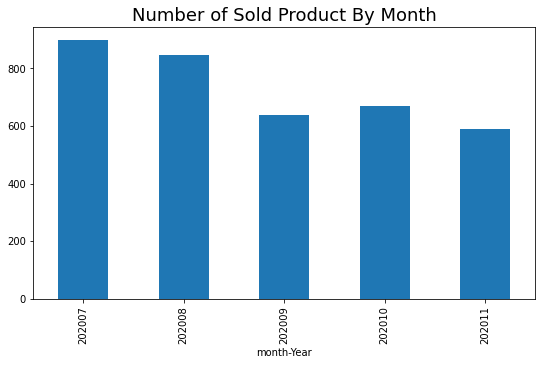

In [ ]:
sales.groupby("month-Year")["Kode Barang"].nunique().plot(kind="bar",figsize=(9,5))
plt.title("Number of Sold Product By Month",fontsize=18)

Text(0.5, 1.0, 'Percentage of sold product')

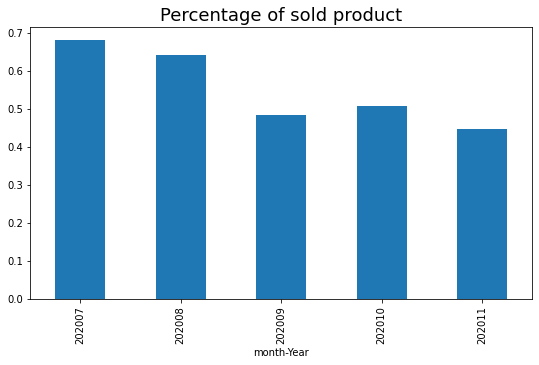

In [ ]:
(sales.groupby("month-Year")["Kode Barang"].nunique()/sales["Kode Barang"].nunique()).plot(kind="bar",figsize=(9,5))
plt.title("Percentage of sold product",fontsize=18)

Text(0.5, 1.0, 'Number of Transaction By Month')

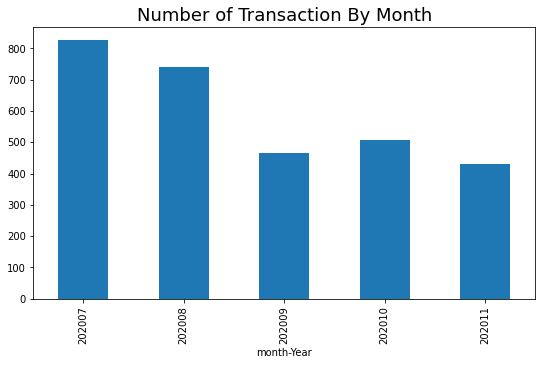

In [ ]:
sales.groupby("month-Year",as_index=True)["No. Invoice"].nunique().plot(kind="bar",figsize=(9,5))
plt.title("Number of Transaction By Month",fontsize=18)

**2. How many new customer every month**

In [ ]:
sales= sales.rename(columns={"Tanggal Invoice": "Tanggal_Invoice"})

In [ ]:
sales_new = sales.groupby("CustomerID").Tanggal_Invoice.min().reset_index()
sales_new.columns = ["CustomerID","FirstPurchase"]
sales = pd.merge(sales, sales_new,on="CustomerID")
sales

,No. Invoice,Tanggal_Invoice,Kode Barang,Nama Customer,Nama Barang,Qty,Harga,Total,CustomerID,month-Year,FirstPurchase
0,INV/20200701/001,2020-07-01 09:10:20.000,15000001,Tilar Handayani,"TAMA HEALTHY MASK - NON MEDICAL 3PLY, WHO RECO...",9,18750,168750,1416,202007,2020-07-01 09:10:20.000
1,INV/20200701/001,2020-07-01 09:10:20.000,30000007,Tilar Handayani,"LIBI, LEBAH KECIL YANG TAKUT - PENGARANG POPI...",9,43800,394200,1416,202007,2020-07-01 09:10:20.000
2,INV/20200701/001,2020-07-01 09:10:20.000,61000008,Tilar Handayani,BB L/L 100L B5 (50),9,8900,80100,1416,202007,2020-07-01 09:10:20.000
3,INV/20200701/001,2020-07-01 09:10:20.000,61000012,Tilar Handayani,BB L/L A5 100 GREEN (50),9,9400,84600,1416,202007,2020-07-01 09:10:20.000
4,INV/20200701/001,2020-07-01 09:10:20.000,61000016,Tilar Handayani,BB L/L A5 100 YELLOW (50),9,9400,84600,1416,202007,2020-07-01 09:10:20.000
...,...,...,...,...,...,...,...,...,...,...,...
8589,INV/20201130/7701,2020-11-30 16:42:16.995,91000126,Intane Jun Pyo,KIKY AMP MERPATI 90 60GR (70),2,18900,37800,745,202011,2020-11-30 16:42:16.995
8590,INV/20201130/7701,2020-11-30 16:42:16.995,91000145,Intane Jun Pyo,KIKY B/KWARTO 200L (60),1,23900,23900,745,202011,2020-11-30 16:42:16.995
8591,INV/20201130/7705,2020-11-30 17:28:20.995,91000186,Helvy,PAPER ONE HVS 70GR F4,2,45000,90000,648,202011,2020-11-30 17:28:20.995
8592,INV/20201130/7705,2020-11-30 17:28:20.995,91000392,Helvy,ZB SARASA CLIP 07 BLUE,1,19500,19500,648,202011,2020-11-30 17:28:20.995


In [ ]:
sales["Class"] = "New"
sales.loc[sales["Tanggal_Invoice"]>sales["FirstPurchase"],"Class"] = "Existing"
sales.head(8)

,No. Invoice,Tanggal_Invoice,Kode Barang,Nama Customer,Nama Barang,Qty,Harga,Total,CustomerID,month-Year,FirstPurchase,Class
0,INV/20200701/001,2020-07-01 09:10:20,15000001,Tilar Handayani,"TAMA HEALTHY MASK - NON MEDICAL 3PLY, WHO RECO...",9,18750,168750,1416,202007,2020-07-01 09:10:20,New
1,INV/20200701/001,2020-07-01 09:10:20,30000007,Tilar Handayani,"LIBI, LEBAH KECIL YANG TAKUT - PENGARANG POPI...",9,43800,394200,1416,202007,2020-07-01 09:10:20,New
2,INV/20200701/001,2020-07-01 09:10:20,61000008,Tilar Handayani,BB L/L 100L B5 (50),9,8900,80100,1416,202007,2020-07-01 09:10:20,New
3,INV/20200701/001,2020-07-01 09:10:20,61000012,Tilar Handayani,BB L/L A5 100 GREEN (50),9,9400,84600,1416,202007,2020-07-01 09:10:20,New
4,INV/20200701/001,2020-07-01 09:10:20,61000016,Tilar Handayani,BB L/L A5 100 YELLOW (50),9,9400,84600,1416,202007,2020-07-01 09:10:20,New
5,INV/20200701/002,2020-07-01 10:16:20,61000027,Ika Kurniawati,BB L/L B5 100 RAINBOW(25),9,15000,135000,709,202007,2020-07-01 10:16:20,New
6,INV/20200701/002,2020-07-01 10:16:20,61000035,Ika Kurniawati,BTF BUSUR 180/10 (960),9,2200,19800,709,202007,2020-07-01 10:16:20,New
7,INV/20200701/002,2020-07-01 10:16:20,61000045,Ika Kurniawati,BTF MST 15CM (2400),9,1700,15300,709,202007,2020-07-01 10:16:20,New


In [ ]:
sales.to_excel("/content/drive/My Drive/Dataset_Literata/2. Hasil_Labelling.xlsx", index=False)

In [ ]:
sales["Class"].unique()

array(['New', 'Existing'], dtype=object)

Text(0.5, 1.0, 'Number of New Customer Per Month')

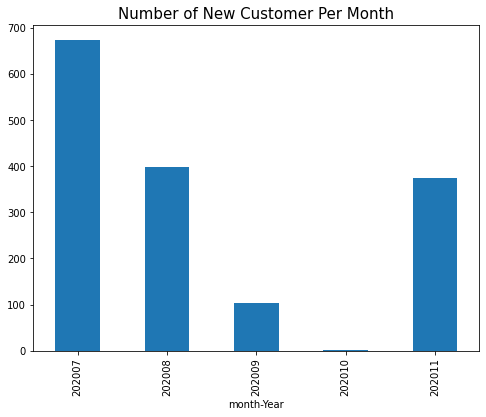

In [ ]:
sales.loc[sales["Class"]=="New"].groupby("month-Year")["CustomerID"].nunique().plot(kind="bar", figsize=(8,6))
plt.title("Number of New Customer Per Month", fontsize=15)

**3. Retention Rate Setiap Bulan**

(tingkat atau rata - rata jumlah pelanggan lama yang tetap bertahan untuk membeli produk)

Text(0.5, 1.0, 'Retention Rate By Month')

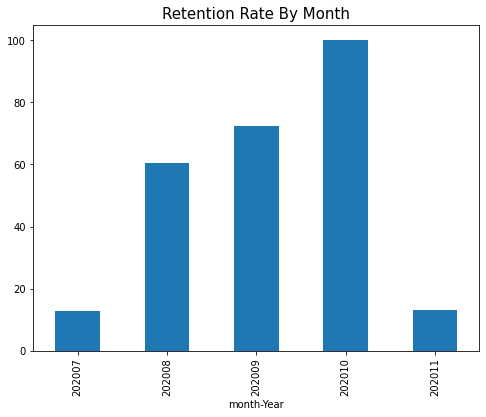

In [ ]:
(sales.loc[sales["Class"]=="Existing"].groupby("month-Year")["CustomerID"].nunique()/sales.groupby("month-Year")["CustomerID"].nunique()*100).plot(kind="bar", figsize=(8,6))
plt.title("Retention Rate By Month", fontsize=15)

**Retention Rate setiap bulan terus mengalami kenaikan. Pada November 2020 mengalami penurunan yang signifikan...**

**4 italicized text. Jarak rata-rata antar transaksi per pelanggan**

In [ ]:
sales_dist = sales.sort_values(by=["CustomerID","Tanggal_Invoice"], axis=0, inplace=False)
sales_dist = sales_dist.drop_duplicates(subset="No. Invoice")

In [ ]:
ids = []
distc = []
t = ""

for index, row in sales_dist.iterrows():
    if row["CustomerID"] in ids:
        distc.append(round((row["Tanggal_Invoice"] - t).total_seconds()/86400,2))
        t = row["Tanggal_Invoice"]
    else:
        ids.append(row["CustomerID"])
        t = row["Tanggal_Invoice"]
        distc.append(0)

In [ ]:
sales_dist["between_trans"] = distc
sales_avg_dist = sales_dist.groupby("CustomerID").between_trans.median().reset_index()
sales_avg_dist.columns=["CustomerID","avgDistance"]

In [ ]:
sales_avg_dist.loc[sales_avg_dist["avgDistance"]>0]["avgDistance"].describe()

count    809.000000
mean      22.410216
std       12.549306
min        0.010000
25%       14.010000
50%       21.140000
75%       35.910000
max       40.940000
Name: avgDistance, dtype: float64

In [ ]:
plot_data = [
    go.Histogram(
        x=sales_avg_dist.loc[sales_avg_dist["avgDistance"]>0]["avgDistance"]
    )
]

plot_layout = go.Layout(
        title='Avg. Days Between Transaction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# RFM - AR Analysis

In [ ]:
#Take only non minus data
sales_minus = sales.loc[sales["Total"]<=0]
sales_non_minus = sales.loc[sales["Total"]>0]

In [ ]:
sales_non_minus_id = pd.DataFrame(sales_non_minus["CustomerID"].unique())
sales_non_minus_id.columns = ["CustomerID"] 

In [ ]:
sales_max_purchase = sales_non_minus.groupby("CustomerID").Tanggal_Invoice.max().reset_index(name="LastPurchaseDate")

## Recency

In [ ]:
last_transaction = sales_max_purchase["LastPurchaseDate"].max() 
sales_max_purchase["Recency"] = ( last_transaction - sales_max_purchase["LastPurchaseDate"])
sales_max_purchase["Recency"] = [round(x.total_seconds()/86400,2) for x in sales_max_purchase["Recency"]]
sales_max_purchase.sort_values(by="LastPurchaseDate")

,CustomerID,LastPurchaseDate,Recency
1416,1416,2020-07-01 09:10:20.000,152.35
709,709,2020-07-01 10:16:20.000,152.30
48,48,2020-07-01 11:00:20.000,152.27
202,202,2020-07-01 11:20:34.000,152.26
375,375,2020-07-01 11:55:26.000,152.23
...,...,...,...
1372,1372,2020-11-30 15:10:08.995,0.10
716,716,2020-11-30 15:44:41.995,0.07
935,935,2020-11-30 16:19:14.995,0.05
745,745,2020-11-30 16:42:16.995,0.03


In [ ]:
rfm_df = pd.merge(sales_non_minus_id, sales_max_purchase, on="CustomerID")
rfm_df.drop(["LastPurchaseDate"],axis=1, inplace=True)
rfm_df

,CustomerID,Recency
0,1416,152.35
1,709,152.30
2,48,152.27
3,202,152.26
4,1317,151.20
...,...,...
1546,1372,0.10
1547,716,0.07
1548,935,0.05
1549,745,0.03


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/3. RFM_Recency.xlsx", index=False)

In [ ]:
plot_data = [
    go.Histogram(
        x=rfm_df['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Frequency 

In [ ]:
sales_freq = pd.DataFrame(sales_non_minus.groupby("CustomerID")["No. Invoice"].nunique().reset_index())
sales_freq.columns = ["CustomerID","Frequency"]
sales_freq.sort_values('Frequency', ascending=False)

,CustomerID,Frequency
983,983,28
527,527,14
887,887,8
560,560,6
74,74,5
...,...,...
713,713,1
714,714,1
715,715,1
716,716,1


In [ ]:
sales_freq.to_excel("/content/drive/My Drive/Dataset_Literata/4. RFM_Frequency.xlsx", index=False)

In [ ]:
#merge dataset
rfm_df = pd.merge(rfm_df, sales_freq, on="CustomerID")
rfm_df

,CustomerID,Recency,Frequency
0,1416,152.35,1
1,709,152.30,1
2,48,152.27,1
3,202,152.26,1
4,1317,151.20,2
...,...,...,...
1546,1372,0.10,1
1547,716,0.07,1
1548,935,0.05,1
1549,745,0.03,1


In [ ]:
plot_data = [
    go.Histogram(
        x=rfm_df['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Monetary

In [ ]:
sales_mon = pd.DataFrame(sales_non_minus.groupby("CustomerID")["Total"].sum().reset_index())
sales_mon.columns = ["CustomerID","Monetary"]
sales_mon.sort_values('Monetary', ascending=False)

,CustomerID,Monetary
63,63,41782900
527,527,4287600
1296,1296,3446000
921,921,2644700
983,983,2602300
...,...,...
1010,1010,3000
2,2,2200
466,466,2200
199,199,1100


In [ ]:
sales_mon.to_excel("/content/drive/My Drive/Dataset_Literata/5. RFM_Monetary.xlsx", index=False)

In [ ]:
rfm_df = pd.merge(sales_mon, rfm_df, on="CustomerID")
rfm_df

,CustomerID,Monetary,Recency,Frequency
0,0,216000,72.10,1
1,1,15600,148.11,1
2,2,2200,4.90,1
3,3,362900,147.88,1
4,4,160000,146.09,1
...,...,...,...,...
1546,1546,853850,45.99,3
1547,1547,200000,96.10,2
1548,1548,215600,57.27,2
1549,1549,41900,35.10,2


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/6. RFM_Complate.xlsx", index=False)

In [ ]:
plot_data = [
    go.Histogram(
        x=rfm_df['Monetary']
    )
]

plot_layout = go.Layout(
        title='Monetary'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Age(Days)

In [ ]:
last_purchase = sales_non_minus["Tanggal_Invoice"].max()
customer_since = sales_non_minus.groupby("CustomerID").Tanggal_Invoice.min().reset_index()
customer_since.columns = ["CustomerID", "FirstPurchase"]
customer_since["Age(Days)"] = (last_purchase - customer_since["FirstPurchase"])
customer_since["Age(Days)"] = [round(x.total_seconds()/86400,2) for x in customer_since["Age(Days)"]]

In [ ]:
#merge dataframe
rfm_df = pd.merge(rfm_df, customer_since, on="CustomerID")
rfm_df.sort_values('Age(Days)', ascending=False)

,CustomerID,Monetary,Recency,Frequency,FirstPurchase,Age(Days)
1416,1416,812250,152.35,1,2020-07-01 09:10:20.000,152.35
709,709,261800,152.30,1,2020-07-01 10:16:20.000,152.30
48,48,38000,152.27,1,2020-07-01 11:00:20.000,152.27
202,202,12200,152.26,1,2020-07-01 11:20:34.000,152.26
1428,1428,50800,151.15,2,2020-07-01 11:31:11.000,152.25
...,...,...,...,...,...,...
299,299,18000,0.10,1,2020-11-30 14:58:37.995,0.10
716,716,21250,0.07,1,2020-11-30 15:44:41.995,0.07
935,935,27200,0.05,1,2020-11-30 16:19:14.995,0.05
745,745,123300,0.03,1,2020-11-30 16:42:16.995,0.03


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/7. RFM-AR_Age+First Purchase.xlsx", index=False)

In [ ]:
rfm_df.drop(["FirstPurchase"], axis=1, inplace=True)
rfm_df

,CustomerID,Monetary,Recency,Frequency,Age(Days)
0,0,216000,72.10,1,72.10
1,1,15600,148.11,1,148.11
2,2,2200,4.90,1,4.90
3,3,362900,147.88,1,147.88
4,4,160000,146.09,1,146.09
...,...,...,...,...,...
1546,1546,853850,45.99,3,127.25
1547,1547,200000,96.10,2,124.11
1548,1548,215600,57.27,2,135.07
1549,1549,41900,35.10,2,111.05


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/8. RFM-AR_Age.xlsx", index=False)

In [ ]:
rfm_df.sort_values('Age(Days)', ascending=False)

,CustomerID,Monetary,Recency,Frequency,Age(Days)
1416,1416,812250,152.35,1,152.35
709,709,261800,152.30,1,152.30
48,48,38000,152.27,1,152.27
202,202,12200,152.26,1,152.26
1428,1428,50800,151.15,2,152.25
...,...,...,...,...,...
299,299,18000,0.10,1,0.10
716,716,21250,0.07,1,0.07
935,935,27200,0.05,1,0.05
745,745,123300,0.03,1,0.03


In [ ]:
plot_data = [
    go.Histogram(
        x=rfm_df['Age(Days)']
    )
]

plot_layout = go.Layout(
        title='Age(Days)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Return (Days)

In [ ]:
rfm_df = pd.merge(rfm_df, sales_avg_dist, on="CustomerID")
rfm_df.rename({"AvgDistance":"Return(Days)"})

,CustomerID,Monetary,Recency,Frequency,Age(Days),avgDistance
0,0,216000,72.10,1,72.10,0.000
1,1,15600,148.11,1,148.11,0.000
2,2,2200,4.90,1,4.90,0.000
3,3,362900,147.88,1,147.88,0.000
4,4,160000,146.09,1,146.09,0.000
...,...,...,...,...,...,...
1546,1546,853850,45.99,3,127.25,33.900
1547,1547,200000,96.10,2,124.11,14.005
1548,1548,215600,57.27,2,135.07,38.900
1549,1549,41900,35.10,2,111.05,37.975


In [ ]:
rfm_df.sort_values('avgDistance', ascending=False)

,CustomerID,Monetary,Recency,Frequency,Age(Days),avgDistance
987,987,205700,48.14,2,130.02,40.94
465,465,312800,48.15,2,130.02,40.94
432,432,193200,48.13,2,129.99,40.93
617,617,156600,48.12,2,129.96,40.92
927,927,651700,48.20,2,130.05,40.92
...,...,...,...,...,...,...
713,713,495000,148.15,1,148.15,0.00
714,714,259200,146.90,1,146.90,0.00
715,715,252200,77.07,1,77.07,0.00
716,716,21250,0.07,1,0.07,0.00


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/9. RFM-AR_Return.xlsx", index=False)

In [ ]:
plot_data = [
    go.Histogram(
        x=rfm_df['avgDistance']
    )
]

plot_layout = go.Layout(
        title='Return(Days)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Clustering with RFM-AR

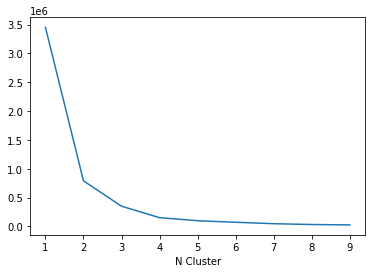

In [ ]:
sse = {}
recency_df = rfm_df[["Recency"]]
for i in range(1,10):
    model = KMeans(n_clusters=i, max_iter=1000).fit(recency_df)
    recency_df["recency_c"] = model.labels_
    sse[i] = model.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("N Cluster")
plt.show()

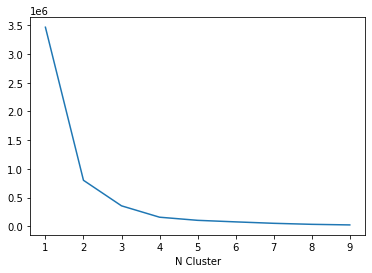

In [ ]:
sse = {}
frequency_df = rfm_df[["Frequency"]]
for i in range(1,10):
    model = KMeans(n_clusters=i, max_iter=1000).fit(recency_df)
    frequency_df["frequency_c"] = model.labels_
    sse[i] = model.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("N Cluster")
plt.show()

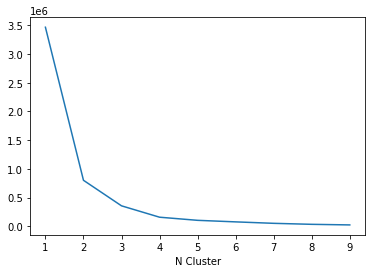

In [ ]:
sse = {}
monetary_df = rfm_df[["Monetary"]]
for i in range(1,10):
    model = KMeans(n_clusters=i, max_iter=1000).fit(recency_df)
    monetary_df["monetary_c"] = model.labels_
    sse[i] = model.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("N Cluster")
plt.show()

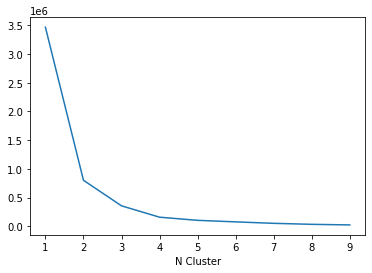

In [ ]:
sse = {}
frequency_df = rfm_df[["Age(Days)"]]
for i in range(1,10):
    model = KMeans(n_clusters=i, max_iter=1000).fit(recency_df)
    frequency_df["age_c"] = model.labels_
    sse[i] = model.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("N Cluster")
plt.show()

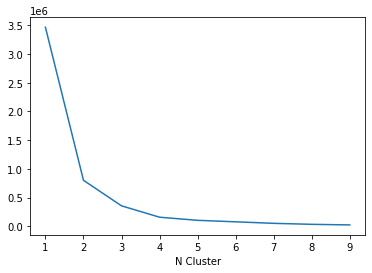

In [ ]:
#rename column
rfm_df.rename({"avgDistance":"Return(Days)"},axis=1,inplace=True)

sse = {}
frequency_df = rfm_df[["Return(Days)"]]
for i in range(1,10):
    model = KMeans(n_clusters=i, max_iter=1000).fit(recency_df)
    frequency_df["return_c"] = model.labels_
    sse[i] = model.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("N Cluster")
plt.show()

In [ ]:
rfm_df.sort_values('Frequency', ascending=False)

,CustomerID,Monetary,Recency,Frequency,Age(Days),Return(Days)
983,983,2602300,143.85,28,144.86,0.020
527,527,4287600,52.85,14,133.20,0.055
887,887,719300,34.34,8,113.27,0.000
560,560,1145800,32.30,6,107.03,11.820
74,74,298800,40.30,5,117.24,14.970
...,...,...,...,...,...,...
713,713,495000,148.15,1,148.15,0.000
714,714,259200,146.90,1,146.90,0.000
715,715,252200,77.07,1,77.07,0.000
716,716,21250,0.07,1,0.07,0.000


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/10. RFM-AR_Complate.xlsx", index=False)

## Clustering With K-MEANS

In [ ]:
#define function to reorder cluster
def reorder_cluster(var,target_var,df,ascending):
    
    #grouping by recency group
    df_new = df.groupby(var)[target_var].mean().reset_index()
    #sort values and set index
    df_new = df_new.sort_values(by=target_var,ascending=ascending).reset_index(drop=True)  
    
    #replace cluster with index
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[var,'index']], on=var)    
    df_final = df_final.drop([var],axis=1)
    df_final = df_final.rename(columns={"index":var})
    return df_final

In [ ]:
model = KMeans(n_clusters=4, max_iter=1000)
model.fit(rfm_df[["Recency"]])
rfm_df["recency_c2"] = model.predict(rfm_df[["Recency"]])
rfm_df = reorder_cluster("recency_c2","Recency",rfm_df,ascending=False)

In [ ]:
model = KMeans(n_clusters=4, max_iter=1000)
model.fit(rfm_df[["Frequency"]])
rfm_df["frequency_c2"] = model.predict(rfm_df[["Frequency"]])
rfm_df = reorder_cluster("frequency_c2","Frequency",rfm_df,ascending=True)

In [ ]:
model = KMeans(n_clusters=4, max_iter=1000)
model.fit(rfm_df[["Monetary"]])
rfm_df["monetary_c2"] = model.predict(rfm_df[["Monetary"]])
rfm_df = reorder_cluster("monetary_c2","Monetary",rfm_df,ascending=True)

In [ ]:
model = KMeans(n_clusters=4, max_iter=1000)
model.fit(rfm_df[["Age(Days)"]])
rfm_df["age_c2"] = model.predict(rfm_df[["Age(Days)"]])
rfm_df = reorder_cluster("age_c2","Age(Days)",rfm_df,ascending=True)

In [ ]:
rfm_df.groupby("recency_c2")["Recency"].describe()

,count,mean,std,min,25%,50%,75%,max
recency_c2,,,,,,,,
0,310.0,143.267000,9.471416,121.86,143.0925,146.87,149.895,152.35
1,258.0,89.563101,11.538293,69.99,78.1125,93.19,97.235,113.23
2,521.0,49.777409,9.804257,32.88,42.0600,49.02,58.000,69.35
3,462.0,15.617814,9.409776,0.00,7.9950,15.95,23.185,32.34


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/11. Recency_Describe.xlsx", index=False)

In [ ]:
rfm_df.groupby("frequency_c2")["Frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_c2,,,,,,,,
0,731.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,385.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,433.0,3.323326,0.606169,3.0,3.0,3.0,4.0,8.0
3,2.0,21.000000,9.899495,14.0,17.5,21.0,24.5,28.0


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/12. Frequency_Describe.xlsx", index=False)

In [ ]:
rfm_df.groupby("monetary_c2")["Monetary"].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_c2,,,,,,,,
0,1063.0,1.426978e+05,106172.331634,1100.0,45550.0,125900.0,224700.0,380400.0
1,418.0,6.215358e+05,176678.465617,385200.0,472250.0,587400.0,745700.0,1064500.0
2,69.0,1.517876e+06,546614.480408,1075500.0,1204900.0,1339200.0,1578800.0,4287600.0
3,1.0,4.178290e+07,NaN,41782900.0,41782900.0,41782900.0,41782900.0,41782900.0


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/13. Monetary_Describe.xlsx", index=False)

## Scoring

## Overall Scoring

In [ ]:
rfm_df["Score"] = rfm_df["recency_c2"] + rfm_df["frequency_c2"] + rfm_df["monetary_c2"] + rfm_df["age_c2"]

In [ ]:
rfm_df.groupby("Score", as_index=False)[["Recency","Frequency", "Monetary","Age(Days)","Return(Days)"]].mean()

,Score,Recency,Frequency,Monetary,Age(Days),Return(Days)
0,2,87.860375,1.000000,1.303331e+05,87.860375,0.000000
1,3,66.342779,1.000000,1.167242e+05,66.342779,0.000000
2,4,83.895779,1.623116,3.416319e+05,101.231558,8.667864
3,5,71.625469,2.125000,4.231730e+05,110.028359,17.786289
4,6,56.750963,2.655556,3.182242e+05,122.983148,26.920593
5,7,49.510901,3.153153,5.969489e+05,123.380405,24.378311
6,8,46.847703,3.581081,1.597187e+06,120.909189,16.783176
7,9,38.327500,3.833333,1.546392e+06,117.245000,17.146667
8,10,52.850000,14.000000,4.287600e+06,133.200000,0.055000


In [ ]:
rfm_df.sort_values('Score', ascending=False)

,CustomerID,Monetary,Recency,Frequency,Age(Days),Return(Days),recency_c2,frequency_c2,monetary_c2,age_c2,Score
1175,527,4287600,52.85,14,133.20,0.055,2,3,2,3,10
676,1232,2204400,29.94,4,111.20,16.780,3,2,2,2,9
671,516,1211400,32.05,4,109.33,23.035,3,2,2,2,9
673,679,1357300,32.13,4,108.22,22.160,3,2,2,2,9
674,976,1086400,30.17,4,109.91,15.930,3,2,2,2,9
...,...,...,...,...,...,...,...,...,...,...,...
56,1226,83200,78.31,1,78.31,0.000,1,0,0,1,2
57,1247,84100,76.33,1,76.33,0.000,1,0,0,1,2
58,1305,18900,97.97,1,97.97,0.000,1,0,0,1,2
59,1307,21700,95.89,1,95.89,0.000,1,0,0,1,2


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/14. RFM_Scoring.xlsx", index=False)

In [ ]:
rfm_df["Cluster"] = ["A" if x >= 9 else "B" if ((x < 9) & (x >=4)) else "C" for x in rfm_df["Score"]]

In [ ]:
rfm_df.sort_values('Score', ascending=False)

,CustomerID,Monetary,Recency,Frequency,Age(Days),Return(Days),recency_c2,frequency_c2,monetary_c2,age_c2,Score,Cluster
1175,527,4287600,52.85,14,133.20,0.055,2,3,2,3,10,A
676,1232,2204400,29.94,4,111.20,16.780,3,2,2,2,9,A
671,516,1211400,32.05,4,109.33,23.035,3,2,2,2,9,A
673,679,1357300,32.13,4,108.22,22.160,3,2,2,2,9,A
674,976,1086400,30.17,4,109.91,15.930,3,2,2,2,9,A
...,...,...,...,...,...,...,...,...,...,...,...,...
56,1226,83200,78.31,1,78.31,0.000,1,0,0,1,2,C
57,1247,84100,76.33,1,76.33,0.000,1,0,0,1,2,C
58,1305,18900,97.97,1,97.97,0.000,1,0,0,1,2,C
59,1307,21700,95.89,1,95.89,0.000,1,0,0,1,2,C


In [ ]:
rfm_df.to_excel("/content/drive/My Drive/Dataset_Literata/15. RFM_Grade.xlsx", index=False)

## Obcserve The Clusters

In [ ]:
plot_data = [
    go.Scatter(
        x=rfm_df.query("Cluster == 'A'")['Frequency'],
        y=rfm_df.query("Cluster == 'A'")['Monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
     go.Scatter(
        x=rfm_df.query("Cluster == 'B'")['Frequency'],
        y=rfm_df.query("Cluster == 'B'")['Monetary'],
        mode='markers',
        name='Mid',
         marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
    
     go.Scatter(
        x=rfm_df.query("Cluster == 'C'")['Frequency'],
        y=rfm_df.query("Cluster == 'C'")['Monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
     go.Scatter(
        x=rfm_df.query("Cluster == 'D'")['Frequency'],
        y=rfm_df.query("Cluster == 'D'")['Monetary'],
        mode='markers',
        name='Low',
         marker= dict(size= 9,
            line= dict(width=1),
            color= 'red',
            opacity= 0.5
           )
    ),


]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
plot_data = [
    go.Scatter(
        x=rfm_df.query("Cluster == 'A'")['Recency'],
        y=rfm_df.query("Cluster == 'A'")['Monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
     go.Scatter(
        x=rfm_df.query("Cluster == 'B'")['Recency'],
        y=rfm_df.query("Cluster == 'B'")['Monetary'],
        mode='markers',
        name='Mid',
         marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
    
     go.Scatter(
        x=rfm_df.query("Cluster == 'C'")['Recency'],
        y=rfm_df.query("Cluster == 'C'")['Monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    )


]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
plot_data = [
    go.Scatter(
        x=rfm_df.query("Cluster == 'A'")['Age(Days)'],
        y=rfm_df.query("Cluster == 'A'")['Monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
     go.Scatter(
        x=rfm_df.query("Cluster == 'B'")['Age(Days)'],
        y=rfm_df.query("Cluster == 'B'")['Monetary'],
        mode='markers',
        name='Mid',
         marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
    
     go.Scatter(
        x=rfm_df.query("Cluster == 'C'")['Age(Days)'],
        y=rfm_df.query("Cluster == 'C'")['Monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    )


]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Age(Days)"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)